In [1]:
import imageio
import numpy as np
import matplotlib.pyplot as plt
from skimage.transform import resize
from tqdm import tqdm
import networkx as nx

# Loading image

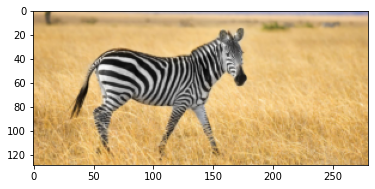

In [2]:
zebra_path = '../images/zebra.jpg'
image = imageio.imread(zebra_path).astype(np.uint8)
image = (255*resize(image, (image.shape[0]//4, image.shape[1]//4))).astype(np.uint8)
plt.imshow(image)
plt.show()

# Extracting mask and target

In [3]:
# Simple filtering to extract the zebra
filtered = 1 - (image.min(axis=2) < 160) * (image.max(axis=2) > 180)

mask = np.ones(image.shape).astype(int)

# Entry point to build the mask using DFS
entry_point = (60, 100)

# DFS
to_visit = [entry_point]
seen = {entry_point}
while len(to_visit) > 0:
    p = to_visit.pop()
    mask[p] = 0
    right = (p[0], p[1]+1)
    left = (p[0], p[1]-1)
    up = (p[0]+1, p[1])
    down = (p[0]-1, p[1])
    for ngh in [right, left, up, down]:
        if (not ngh in seen) and filtered[ngh]:
            to_visit.append(ngh)
            seen.add(ngh)

# Enlarge the mask a little bit 
border_width = 3
for p in seen:
    mask[p[0]-border_width:p[0]+border_width, p[1]-border_width:p[1]+border_width] = 0
    
# Get the target
target = image*mask

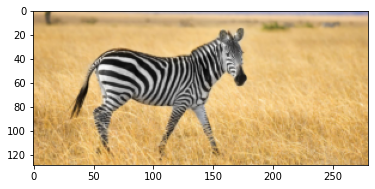

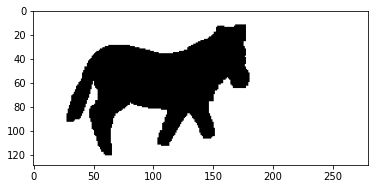

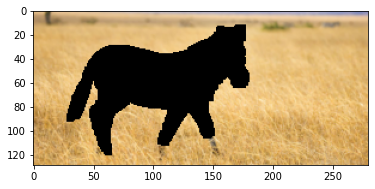

In [4]:
plt.imshow(image)
plt.show()
plt.imshow(255*mask)
plt.show()
plt.imshow(target)
plt.show()

# Paper implementation

### Variables

In [5]:
delta = 8
gap = delta // 2

### Functions

In [6]:
def extract_patch(img, p):
    return img[p[0]-gap:p[0]+gap, p[1]-gap:p[1]+gap]

In [7]:
def apply_patch(img, p, patch):
    img[p[0]-gap:p[0]+gap, p[1]-gap:p[1]+gap] = patch

In [8]:
def Vp(p, x):
    patch_p = extract_patch(image, p)
    patch_x = extract_patch(image, x)
    patch_mask = extract_patch(mask, p)
    return (patch_mask*(patch_p - patch_x)**2).sum()

In [9]:
def Vpq(p, q, xp, xq):
    image_p = np.zeros(image.shape)
    apply_patch(image_p, p, extract_patch(image, xp))
    image_q = np.zeros(image.shape)
    apply_patch(image_q, q, extract_patch(image, xq))
    
    return ((image_p * image_q)**2).sum()

In [10]:
def F(x):
    f = sum([Vp(nodes[i], labels[x[i]]) for i in range(len(nodes))])
    for i, j in edges:
        f += Vpq(nodes[i], nodes[j], labels[x[i]], labels[x[j]])
    return f

# Extracting labels

In [33]:
n_labels = 10
labels = []
while len(labels) < n_labels:
    label = np.random.randint(gap+1, image.shape[0]-gap-1), np.random.randint(gap+1, image.shape[1]-gap-1)
    if mask[label][0]:
        labels.append(label)

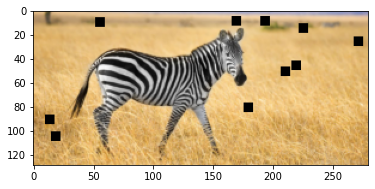

In [34]:
# Show labels

img = image.copy()
for p in labels:
    img[p[0]-gap:p[0]+gap, p[1]-gap:p[1]+gap] = 0

plt.imshow(img)
plt.show()

# Computing the graph

In [17]:
nodes, edges = [], []

for i in range(gap, image.shape[0], gap):
    for j in range(gap, image.shape[1], gap):
        try:
            if (not mask[i,j,0]) or (not mask[i+gap,j+gap,0]) or (not mask[i+gap,j-gap,0]) or (not mask[i-gap,j+gap,0]) or (not mask[i-gap,j-gap,0]):
                nodes.append((i, j))
        except:
            pass

def are_ngh(i, j):
    node1, node2 = nodes[i], nodes[j]
    if node1[0] == node2[0]:
        return np.abs(node1[1] - node2[1]) <= gap
    if node1[1] == node2[1]:
        return np.abs(node1[0] - node2[0]) <= gap
    return False
            
for i in range(len(nodes)):
    for j in range(i+1, len(nodes)):
        if are_ngh(i,j):
            edges.append((i, j))
            edges.append((j, i))

In [18]:
graph = nx.Graph()

for i in range(len(nodes)):
    graph.add_node(i)
    
for edge in edges:
    graph.add_edge(*edge)

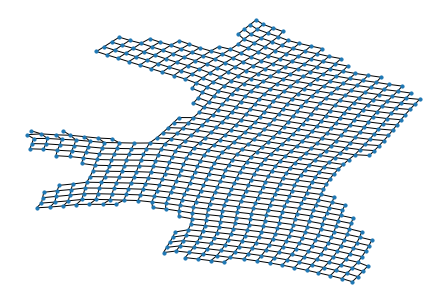

In [19]:
nx.draw_kamada_kawai(graph, node_size=10)

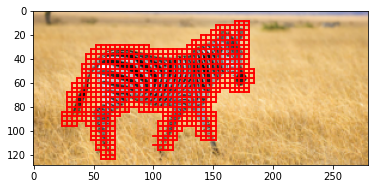

In [20]:
# Show edges and nodes
plt.imshow(image)
    
for i, j in edges:
    plt.plot([nodes[i][1], nodes[j][1]], [nodes[i][0], nodes[j][0]], 'r-')
    
plt.show()

# Belief Propagation

In [31]:
n_edges = len(edges)
n_labels = len(labels)
n_nodes = len(nodes)

In [35]:
n_iter = 2

messages = np.zeros((n_edges, n_labels))
for iteration in range(n_iter):
    messages_update = np.zeros(messages.shape)
    
    progress_bar = tqdm(graph.edges())
    progress_bar.set_description(f"Iteration {iteration}")
    for k, (i, j) in enumerate(progress_bar):
        p, q = nodes[i], nodes[j]
        i_edges = [i_edge for i_edge, (_, to) in enumerate(edges) if to == i]
        messages_in = messages[i_edges]
        for i_label, xq in enumerate(labels): 
            messages_update[k][i_label] = min([Vp(p, xp) 
                                               + Vpq(p, q, xp, xq) 
                                               + messages_in[:, i_label].sum()
                                               for xp in labels])
    messages = messages_update

Iteration 1: 100%|██████████| 1340/1340 [00:26<00:00, 50.07it/s]


In [36]:
beliefs = np.zeros((n_nodes, n_labels))
for i_node, p in enumerate(nodes):
    i_edges = [i_edge for i_edge, (_, j) in enumerate(edges) if j == i_node]
    messages_in = messages[i_edges]
    for i_label, xp in enumerate(labels):
        beliefs[i_node][i_label] = - Vp(p, xp) - messages_in[:, i_label].sum()
        
x_hat = np.argmax(beliefs, axis=1)

# Result

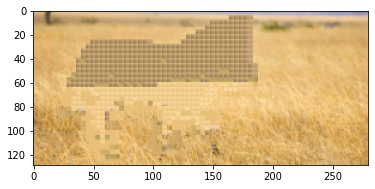

In [37]:
res = target.copy()
for i_node, i_label in enumerate(x_hat):
    apply_patch(res, nodes[i_node], extract_patch(image, labels[i_label]))
plt.imshow(res)
plt.show()